<a href="https://colab.research.google.com/github/ptran1203/gan_project/blob/master/notebooks/classifier_25RAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
from google.colab import drive, output
drive.mount('/content/drive')

!rm -rf '/content/gan_project'
!git clone https://github.com/ptran1203/gan_project
!pip install git+https://www.github.com/keras-team/keras-contrib.git

## for Model definition/training
from keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from keras import applications
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from keras.regularizers import l2
import keras.backend as K
from keras_contrib.applications.resnet import ResNet, basic_block
from keras_contrib.applications.densenet import DenseNet
import keras.applications as k_apps
from keras.layers import (
    Input, Dense, Reshape,
    Flatten, Embedding, Dropout,
    BatchNormalization, Activation,
    Lambda,Layer, Add, Concatenate,
    Average,GlobalAveragePooling2D,
    MaxPooling2D, AveragePooling2D,
)
from keras.layers.convolutional import (
    UpSampling2D, Convolution2D,
    Conv2D, Conv2DTranspose
)
from keras.optimizers import Adam, SGD

from tensorflow.examples.tutorials.mnist import input_data
from keras.utils import to_categorical
import tensorflow as tf 
import numpy as np
import pickle

output.clear()

In [ ]:
cd gan_project

/content/gan_project


In [ ]:
!pip install image-classifiers
from classification_models.keras import Classifiers
from tensorflow.examples.tutorials.mnist import input_data
from keras.preprocessing.image import ImageDataGenerator
import keras.preprocessing.image as iprocess
from mlxtend.plotting import plot_confusion_matrix
import keras
import datetime
from triplet_loss import *
from utils import *
from const import *

import metrics
from visualization import *
from data_augmentation.data_loader import load_gen, load_dataset
from data_augmentation.model import *
import sklearn.metrics as sk_metrics

## Load dataset
# load data
np.random.seed(0)
dataset = 'multi_chest'
resolution = 128
large = 0
train_classes = 80
[
    x_train, y_train, x_val, y_val,
    x_test, y_test , x_unseen, y_unseen
] = load_dataset(dataset, resolution, large, train_classes)

x_train, y_train = prune(x_train, y_train, [1000])
class_counter = dict(Counter(y_train))
Counter(y_train)

Require data augmentation
load data from /content/drive/My Drive/bagan/dataset/multi_chest/imgs_labels_128.pkl successfully

===== data loaded =====

TRAIN:  Counter({0: 3138, 1: 2097, 2: 931, 3: 899, 4: 606, 5: 490, 6: 455, 7: 284, 8: 253, 9: 229, 10: 195, 11: 174, 12: 129, 13: 67, 14: 25})
0
Remove 1000 items in class 0


Counter({0: 2138,
         1: 2097,
         2: 931,
         3: 899,
         4: 606,
         5: 490,
         6: 455,
         7: 284,
         8: 253,
         9: 229,
         10: 195,
         11: 174,
         12: 129,
         13: 67,
         14: 25})

Total classes:  15
Test on 4275 samples
Train on fake data
load data from /content/drive/My Drive/bagan/dataset/multi_chest/imgs_train_gen_v3.pkl successfully
Augment data:  Counter({14: 2113, 13: 2071, 12: 2009, 11: 1964, 10: 1943, 9: 1909, 8: 1885, 7: 1854, 6: 1683, 5: 1648, 4: 1532, 3: 1239, 2: 1207, 1: 41})
Origin data:  Counter({0: 2138, 1: 2097, 2: 931, 3: 899, 4: 606, 5: 490, 6: 455, 7: 284, 8: 253, 9: 229, 10: 195, 11: 174, 12: 129, 13: 67, 14: 25})


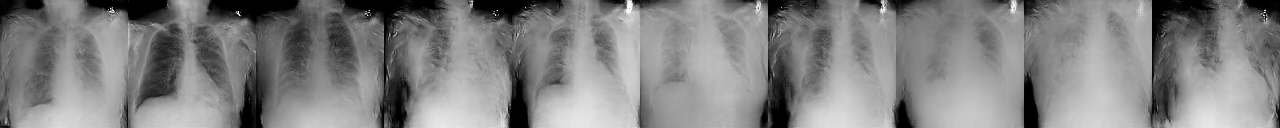

learning rate decay  None
Counter({1: 2138, 4: 2138, 3: 2138, 9: 2138, 0: 2138, 6: 2138, 2: 2138, 5: 2138, 12: 2138, 13: 2138, 8: 2138, 11: 2138, 10: 2138, 7: 2138, 14: 2138})
run experiments 1/5 - BAGAN
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


epochs 1/30 - softmax_loss: 2.151625394821167, l2_loss: 64.11722564697266 - 0:01:28.738766
epochs 2/30 - softmax_loss: 1.4178309440612793, l2_loss: 120.1259994506836 - 0:01:17.204182
epochs 3/30 - softmax_loss: 1.2110687494277954, l2_loss: 122.49153900146484 - 0:01:17.234915
epochs 4/30 - softmax_loss: 1.0924409627914429, l2_loss: 121.93509674072266 - 0:01:17.221566
epochs 5/30 - softmax_loss: 1.0211865901947021, l2_loss: 121.3513412475586 - 0:01:17.195490
epochs 6/30 - softmax_loss: 0.9698089361190796, l2_loss: 120.56407165527344 - 0:01:17.172922
epochs 7/30 - softmax_loss: 0.9254682064056396, l2_loss: 121.12956237792969 - 0:01:17.209700
epochs 8/30 - softmax_loss: 0.8915280699729919, l2_loss: 120.33860

<Figure size 432x288 with 0 Axes>

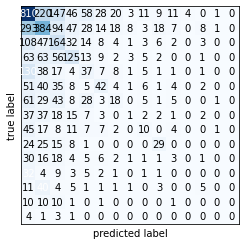

Acc  0.3808187246322632
Auc  [0.70310699 0.68459444 0.75417505 0.80913488 0.70261168 0.76734383
 0.72065012 0.65572627 0.71425998 0.88170452 0.75394077 0.68741465
 0.79870529 0.6675739  0.78397666]
run experiments 2/5 - BAGAN
epochs 1/30 - softmax_loss: 2.0810084342956543, l2_loss: 75.05809020996094 - 0:01:20.961239
epochs 2/30 - softmax_loss: 1.3712549209594727, l2_loss: 117.23614501953125 - 0:01:17.387811
epochs 3/30 - softmax_loss: 1.1730948686599731, l2_loss: 119.7021713256836 - 0:01:17.403788
epochs 4/30 - softmax_loss: 1.0678600072860718, l2_loss: 120.30268096923828 - 0:01:17.369734
epochs 5/30 - softmax_loss: 1.0045193433761597, l2_loss: 118.71684265136719 - 0:01:17.323108
epochs 6/30 - softmax_loss: 0.9559268355369568, l2_loss: 117.14532470703125 - 0:01:17.365936
epochs 7/30 - softmax_loss: 0.916712760925293, l2_loss: 117.19538879394531 - 0:01:17.385017
epochs 8/30 - softmax_loss: 0.8854973316192627, l2_loss: 116.56219482421875 - 0:01:17.314050
epochs 9/30 - softmax_loss: 0.854

<Figure size 432x288 with 0 Axes>

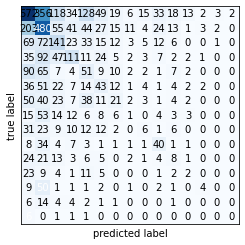

Acc  0.34619882702827454
Auc  [0.69931522 0.68079632 0.73377083 0.81844135 0.70140174 0.75050794
 0.74968095 0.63677494 0.70975387 0.90155434 0.7451826  0.7272902
 0.80578687 0.61103968 0.73376048]
run experiments 3/5 - BAGAN
epochs 1/30 - softmax_loss: 2.1812195777893066, l2_loss: 62.31855392456055 - 0:01:20.890120
epochs 2/30 - softmax_loss: 1.4124599695205688, l2_loss: 117.85668182373047 - 0:01:16.837916
epochs 3/30 - softmax_loss: 1.213716983795166, l2_loss: 121.03457641601562 - 0:01:16.774247
epochs 4/30 - softmax_loss: 1.1089763641357422, l2_loss: 121.2720718383789 - 0:01:16.803775
epochs 5/30 - softmax_loss: 1.0379633903503418, l2_loss: 121.696533203125 - 0:01:16.784813
epochs 6/30 - softmax_loss: 0.9903829097747803, l2_loss: 121.68683624267578 - 0:01:16.747254
epochs 7/30 - softmax_loss: 0.9500958323478699, l2_loss: 121.16677856445312 - 0:01:16.809907
epochs 8/30 - softmax_loss: 0.9152728319168091, l2_loss: 121.3170394897461 - 0:01:16.871836
epochs 9/30 - softmax_loss: 0.884807

<Figure size 432x288 with 0 Axes>

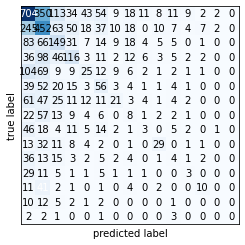

Acc  0.3695906400680542
Auc  [0.70414099 0.68035157 0.75072004 0.80595367 0.67952    0.76787766
 0.74522878 0.63914795 0.69248439 0.89007767 0.71693228 0.71789473
 0.82514143 0.66850256 0.83078085]
run experiments 4/5 - BAGAN
epochs 1/30 - softmax_loss: 2.1744468212127686, l2_loss: 74.2381362915039 - 0:01:21.234882
epochs 2/30 - softmax_loss: 1.3994890451431274, l2_loss: 123.62826538085938 - 0:01:16.506817
epochs 3/30 - softmax_loss: 1.199596881866455, l2_loss: 125.98336791992188 - 0:01:16.501901
epochs 4/30 - softmax_loss: 1.095670223236084, l2_loss: 125.59532928466797 - 0:01:16.458910
epochs 5/30 - softmax_loss: 1.027366042137146, l2_loss: 125.89301300048828 - 0:01:16.414810
epochs 6/30 - softmax_loss: 0.9766559600830078, l2_loss: 125.30420684814453 - 0:01:16.515705
epochs 7/30 - softmax_loss: 0.9351959228515625, l2_loss: 124.97296905517578 - 0:01:16.425167
epochs 8/30 - softmax_loss: 0.9047689437866211, l2_loss: 124.43559265136719 - 0:01:16.426851
epochs 9/30 - softmax_loss: 0.87346

<Figure size 432x288 with 0 Axes>

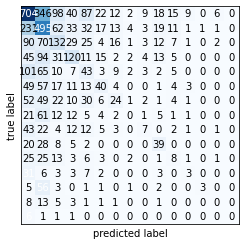

Acc  0.378479540348053
Auc  [0.70395743 0.68169486 0.74801003 0.80725024 0.70356472 0.76122147
 0.75173383 0.62863422 0.7111308  0.91398251 0.7634073  0.68821601
 0.81057842 0.58644436 0.89451477]
run experiments 5/5 - BAGAN
epochs 1/30 - softmax_loss: 2.074493169784546, l2_loss: 72.73967742919922 - 0:01:23.629339
epochs 2/30 - softmax_loss: 1.3835481405258179, l2_loss: 116.37382507324219 - 0:01:18.071622
epochs 3/30 - softmax_loss: 1.1969836950302124, l2_loss: 119.25926208496094 - 0:01:18.151392
epochs 4/30 - softmax_loss: 1.0926214456558228, l2_loss: 119.14788055419922 - 0:01:18.149152
epochs 5/30 - softmax_loss: 1.0197545289993286, l2_loss: 118.7992172241211 - 0:01:18.148532
epochs 6/30 - softmax_loss: 0.9676299095153809, l2_loss: 118.57244873046875 - 0:01:18.109820
epochs 7/30 - softmax_loss: 0.9257579445838928, l2_loss: 118.05091857910156 - 0:01:18.078446
epochs 8/30 - softmax_loss: 0.8898211717605591, l2_loss: 117.90764617919922 - 0:01:18.079076
epochs 9/30 - softmax_loss: 0.8615

<Figure size 432x288 with 0 Axes>

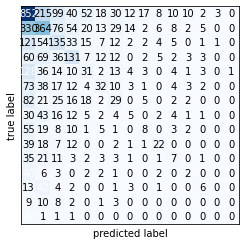

Acc  0.3798830509185791
Auc  [0.6950565  0.67266967 0.74529674 0.81654333 0.6909277  0.76544647
 0.72685373 0.67306795 0.72265451 0.8962894  0.71236728 0.70285503
 0.80841066 0.63007729 0.75649841]
|  | BAGAN |
|--|--|
| No Finding | **0.701** |
| Infiltration | **0.68** |
| Atelectasis | **0.746** |
| Effusion | **0.811** |
| Nodule | **0.696** |
| Pneumothorax | **0.762** |
| Mass | **0.739** |
| Consolidation | **0.647** |
| Pleural_Thickening | **0.71** |
| Cardiomegaly | **0.897** |
| Emphysema | **0.738** |
| Fibrosis | **0.705** |
| Edema | **0.81** |
| Pneumonia | **0.633** |
| Hernia | **0.8** |
| **Average** | **0.738** |



In [ ]:
rst, channel = x_train.shape[2:]
input_shape = (rst, rst, channel)
classes = np.unique(y_train)
num_of_classes = len(classes)
y_train_onehot = to_categorical(y_train, num_of_classes)
y_val_onehot = to_categorical(y_val, num_of_classes)
feat_dims = 128
from_scratch = False

print('Total classes: ', num_of_classes)
print('Test on {} samples'.format(len(y_test)))

frozen_block = []
all_scores = {}
experiments = 5
save = False
opts = [
    # Option.vgg16,
    # Option.vgg16_st_aug,
    # Option.gan_v2,
    # Option.gan_v1,
    Option.bagan
]

feature_extractor = 'vgg16'
learning_rate = 3e-6
loss_weights = [1, 0.001]
epochs = 30

for opt in opts:
    result = run(opt, experiments, frozen_block,
                feature_extractor, save, learning_rate,
                loss_weights, epochs)

    all_scores[model_map[opt]] = result
    send("experiemnts {} \n {}".format(opt, json.dumps(result.tolist(), indent=4)))
table = metrics.draw_md_table(all_scores)
print(table)

# send slack
send(table)

In [ ]:
all_scores

{'BAGAN': array([0.70111543, 0.68002137, 0.74639454, 0.81146469, 0.69560517,
        0.76247947, 0.73882948, 0.64667027, 0.71005671, 0.89672169,
        0.73836605, 0.70473412, 0.80972454, 0.63272756, 0.79990624])}

In [ ]:
save_embbeding(train_model, dataset)

NameError: ignored

In [ ]:
embbeding_model = Model(
    inputs = train_model.inputs[0],
    outputs = train_model.get_layer('side_out').get_output_at(-1)
)
classifier = Model(inputs = train_model.inputs[0], outputs = train_model.get_layer('main_out').get_output_at(-1))
# classifier = flatten_model(classifier)
classifier.compile(optimizer='adam', metrics = ['accuracy'],  loss='categorical_crossentropy')
scatter_plot(x_train, y_train, embbeding_model, 'train')
scatter_plot(x_unseen, y_unseen, embbeding_model, 'val')
scatter_plot(x_test, y_test, embbeding_model, 'test')

In [ ]:

def l2_distance(a, b):
    return np.mean(np.square(a - b))

def cosine_sim(a, b):
    return - (np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))

def cal_sp_vectors(embbeder, supports,k_shot):
    means = []
    x_sp, y_sp = supports
    classes = np.unique(y_sp)
    # perclassid
    per_class_ids = dict()
    ids = np.array(range(len(x_sp)))
    for c in classes:
        per_class_ids[c] = ids[y_sp == c]

    for c in classes:
        imgs = x_sp[per_class_ids[c][:k_shot]]
        # imgs = utils.triple_channels(imgs)
        latent = embbeder.predict(imgs)
        means.append(np.mean(latent, axis=0))
    return np.array(means)
    
def classify_by_metric(embbeder, supports, images, k_shot=1,metric='l2'):
    x_sp, y_sp = supports
    classes = np.unique(y_sp)
    # currently do one-shot classification
    sp_vectors = cal_sp_vectors(embbeder, supports,k_shot)
    vectors = embbeder.predict(triple_channels(images))
    metric_func = l2_distance if metric == 'l2' else cosine_sim
    similiarity = np.array([metric_func(vector, sp_vector) \
                        for vector in vectors \
                        for sp_vector in sp_vectors]).reshape(-1, len(classes))
    pred = np.argmin(np.array(similiarity), axis=1)
    return pred + np.min(classes)

def evaluate_by_metric(embbeder, supports, images, labels, k_shot=1,metric='l2'):
    pred = classify_by_metric(embbeder, supports,
                              images,k_shot=k_shot, metric=metric)

    acc = (pred == labels).mean()
    return acc

# x_train_aug, y_train_aug = load_gen(dataset, 1)
# x_train_aug=triple_channels(x_train_aug)
x_sp_u, x_test_u, y_sp_u, y_test_u = train_test_split(x_unseen, y_unseen)
evaluate_by_metric(embbeding_model,
                   (x_test_u, y_test_u),
                   x_sp_u, y_sp_u,
                   k_shot=5, metric='cosine')
Counter(y_unseen)

In [ ]:
print("Test")
fname = '/content/drive/My Drive/bagan/{}/latent_encoder_{}'.format(dataset, x_train.shape[1])
embbeding_model = None
with open(fname + '.json', 'r') as f:
    global embbeding_model
    embbeding_model = keras.models.model_from_json(f.read())
    embbeding_model.load_weights(fname + '.h5')
    scatter_plot(x_un, y_train, embbeding_model, 'train')